Lab 3

Tăng Mỹ Hân

22520395

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import os
import random

In [3]:
BASE_DIR = "yalefaces"
folders = [
    "person-1",
    "person-2",
    "person-3",
    "person-4",
    "person-5",
    "person-6",
    "person-7",
    "person-8",
    "person-9",
    "person-10",
    "person-11",
    "person-12",
    "person-13",
    "person-14",
    "person-15"
]

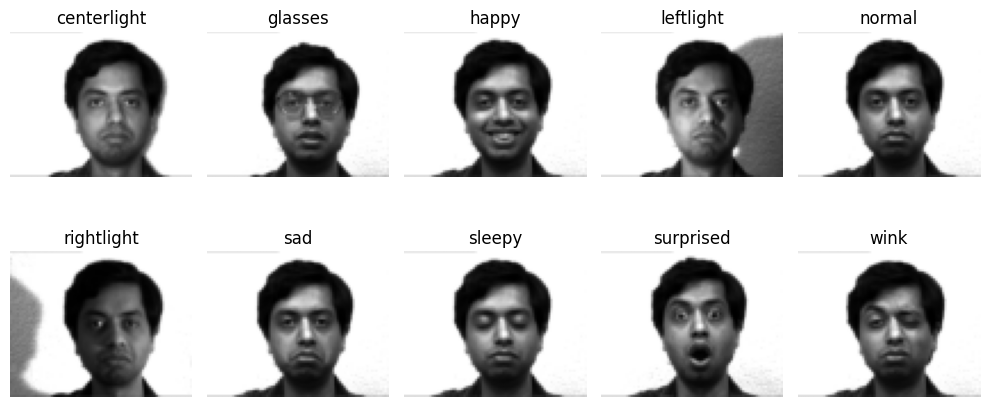

In [4]:
person_folder = random.choice(folders)
plt.figure(figsize=(10, 5))
for ith, filename in enumerate(os.listdir(os.path.join(BASE_DIR, person_folder))):
  image = imread(os.path.join(BASE_DIR, person_folder, filename))
  image = image.squeeze(0)
  image = resize(image, (64, 80), anti_aliasing=True)
  plt.subplot(2, 5, ith + 1)
  plt.imshow(image, cmap="gray")
  plt.axis("off")
  plt.title(filename)
plt.tight_layout()
plt.show()

In [5]:
data = {}
for person_folder in folders:
  for filename in os.listdir(os.path.join(BASE_DIR, person_folder)):
    image = imread(os.path.join(BASE_DIR, person_folder, filename))
    image = resize(image, (1, 64, 80), anti_aliasing=True)
    if person_folder not in data:
      data[person_folder] = [image]
    else:
      data[person_folder].append(image)

for person in data:
  data[person] = np.concat(data[person], axis=0).reshape(10, -1)


In [6]:
def standardizing(images):
  images = (images - images.mean()) / images.std()
  images = images.astype(np.float32)
  return images

# Assignment 1 (4 scores): Implement PCA using Numpy.

In [7]:
class PCA:
  def __init__(self, d_principle: int = 1):
    self.d_principle = d_principle

  def fit(self, X):
    cov = (X.T @ X)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    max_abs_idx = np.argmax(np.abs(eigenvectors), axis=0)
    # eigenvalues = eigenvalues[max_abs_idx]
    signs = np.sign(eigenvectors[max_abs_idx, range(eigenvectors.shape[0])])
    eigenvectors = eigenvectors * signs[np.newaxis,:]
    eigenvectors = eigenvectors.T

    eigen_pair = [(np.abs(eigenvalues[i]), eigenvectors[i,:]) for i in range(eigenvectors.shape[0])]
    eigen_pair.sort(key=lambda x: x[0], reverse=True)

    eigenvalues = np.array([value for (value,_) in eigen_pair])
    eigenvectors = np.array([vector for (_,vector) in eigen_pair])

    self.principle_values = eigenvalues[:self.d_principle]
    self._W = eigenvectors[:self.d_principle]

  def transform(self, X):
    X_hat = self._W @ X
    return X_hat

# Assignment 2 (4 scores):
- Reading the training images.
- Approximating the Principle Space having **20 dimensions**.
- Visualize the base of this Principle Space.

In [8]:
pca = PCA(d_principle=20)

In [9]:
images = []
for person in data:
  images.append(data[person])

images = np.concat(images, axis=0)
images = standardizing(images)
images.shape

(150, 5120)

In [10]:
pca.fit(images)

In [11]:
pca._W.shape

(20, 5120)

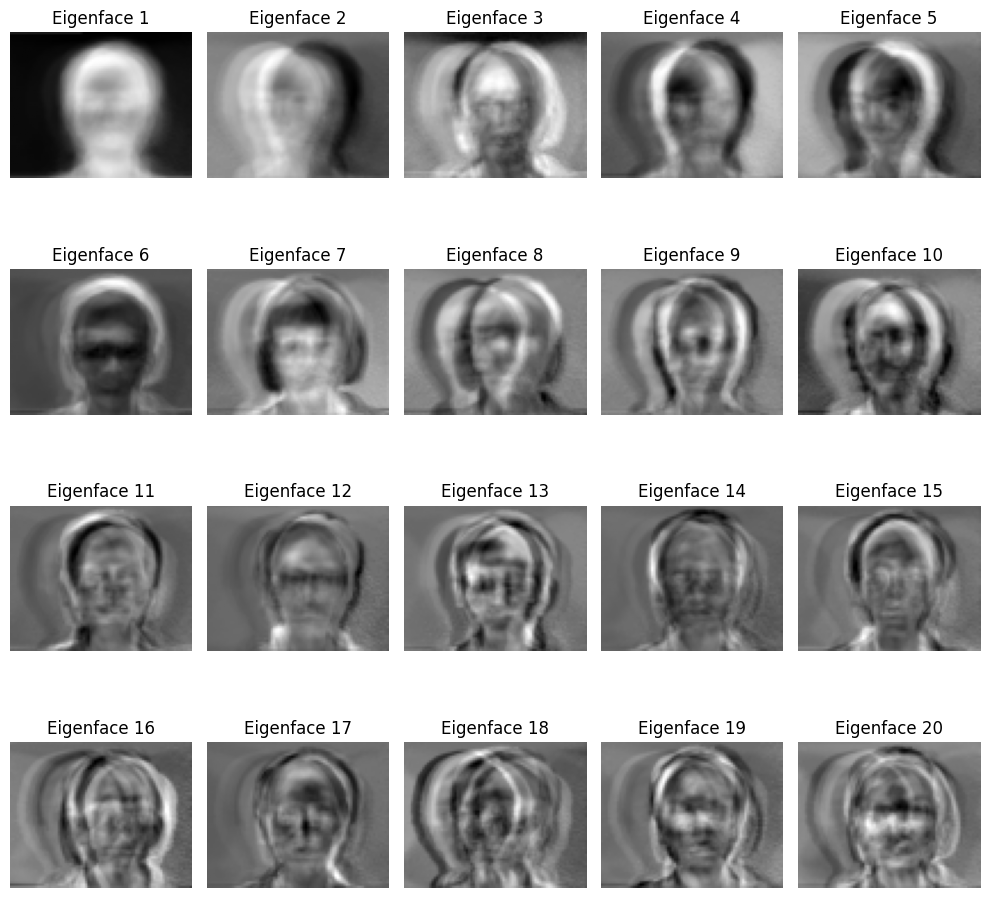

In [12]:
eigenfaces = pca._W
eigenfaces = eigenfaces.reshape(20, 64, 80)
plt.figure(figsize=(10,10))
for i, eigenface in enumerate(eigenfaces):
  plt.subplot(4, 5, i+1)
  plt.imshow(eigenface, cmap="gray")
  plt.axis("off")
  plt.title(f"Eigenface {i+1}")
plt.tight_layout()
plt.show()

In [13]:
mean_faces = {
    person: np.mean(data[person], axis=0) for person in data
}

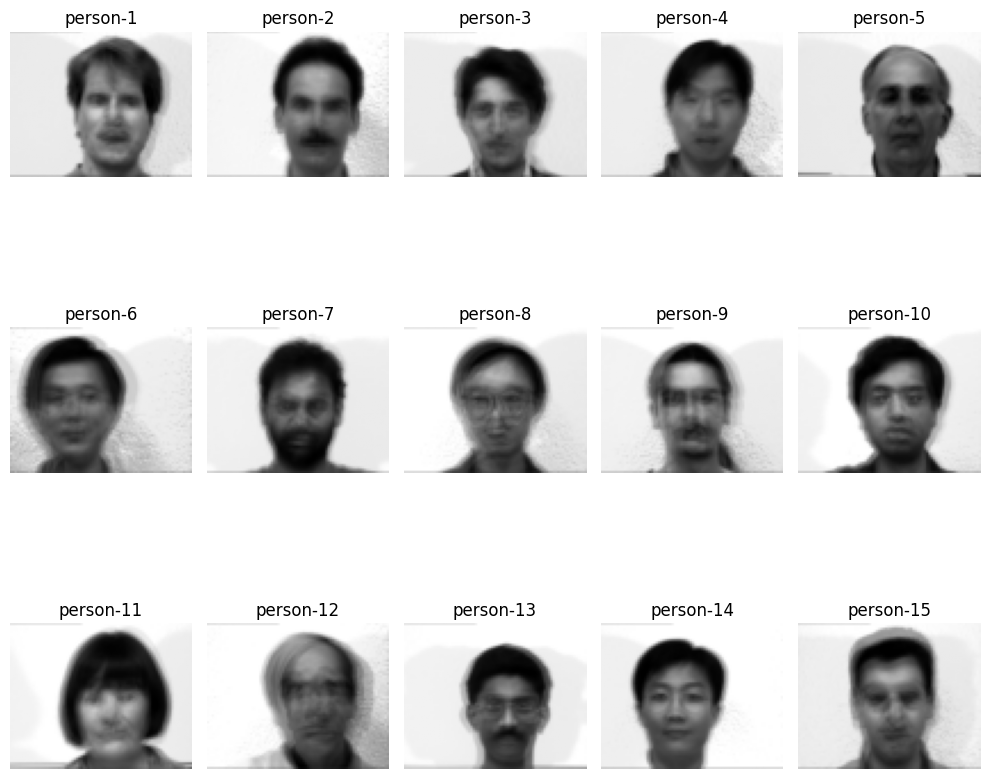

In [14]:
plt.figure(figsize=(10,10))
for i, person in enumerate(mean_faces):
  mean_face = mean_faces[person]
  mean_face = mean_face.reshape(64, 80)
  plt.subplot(3, 5, i+1)
  plt.imshow(mean_face, cmap="gray")
  plt.axis("off")
  plt.title(person)
plt.tight_layout()
plt.show()

In [15]:
projected_mean_faces = {}
for person in mean_faces:
  mean_face = mean_faces[person]
  projected_mean_faces[person] = pca.transform(mean_face)

# Assignment 3 (2 scores):
- Assign persons to the face images in testing data.
- Evaluate the accuracy of this face recognition system.

In [16]:
labels = []
test_images = []
TEST_DIR = "./yalefaces/test"
for filename in os.listdir(os.path.join(TEST_DIR)):
  person_name = filename.split(".")[0]
  labels.append(person_name)
  image = imread(os.path.join(TEST_DIR, filename))
  image = resize(image, (1, 64, 80), anti_aliasing=True)
  test_images.append(image)

test_images = np.concat(test_images, axis=0)
test_images.shape

(15, 64, 80)

In [17]:
labels

['person-1',
 'person-2',
 'person-3',
 'person-5',
 'person-6',
 'person-7',
 'person-8',
 'person-9',
 'person-10',
 'person-11',
 'person-12',
 'person-13',
 'person-14',
 'person-15',
 'person-4']

In [18]:
def Euclide_distance(X,Y):
  assert X.shape == Y.shape
  return (((X - Y)**2).sum())**0.5

In [19]:
prediction = {}
for label, image in zip(labels, test_images):
  image = image.reshape(-1)
  projected_face = pca.transform(image)
  closest_dis = np.inf
  closest_person = None
  for person in projected_mean_faces:
    mean_face = projected_mean_faces[person]
    distance = Euclide_distance(mean_face, projected_face)
    if distance < closest_dis:
      closest_dis = distance
      closest_person = person
  prediction[label] = closest_person

In [20]:
EMs = []
for label in prediction:
    EMs.append(label == prediction[label])
print(f'Accuracy: {np.mean(EMs)*100:0.2f}')

Accuracy: 66.67
